## In this discussion, we will build a basic hybrid CNN-LSTM model for classification on the EEG dataset

#### This notebook has been created by Tonmoy.

## (i) Importing the necessary packages

In [88]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.layers import MultiHeadAttention, concatenate, LayerNormalization, Layer, Embedding, GlobalAveragePooling1D
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf

In [48]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/ECE147-Project/'


Mounted at /content/drive


In [49]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(True)

Num GPUs Available:  0


## (ii) Preprocessing the dataset and preparing the training, validation, and test datasets

In [50]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y



In [95]:
## Loading the dataset


X_test = np.load(data_dir + "X_test.npy")
y_test = np.load(data_dir + "y_test.npy")
X_train_valid = np.load(data_dir + "X_train_valid.npy")
y_train_valid = np.load(data_dir + "y_train_valid.npy")
person_test = np.load(data_dir + "person_test.npy")


## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769



## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


# Transformer mods
X_test_tm = X_test
y_test_tm = y_test
X_train_tm = X_train
y_train_tm = y_train
X_valid_tm = X_valid
y_valid_tm = y_valid
person_test_tm = person_test

y_train_tm = to_categorical(y_train, 4)
y_valid_tm = to_categorical(y_valid, 4)

print("transformer vals:", X_test_tm.shape, y_test_tm.shape, X_train_tm.shape, y_train_tm.shape, X_valid_tm.shape, y_valid_tm.shape)

## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)




transformer vals: (443, 22, 1000) (443,) (1740, 22, 1000) (1740, 4) (375, 22, 1000) (375, 4)
Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training labels after c

## (iii)(CNN-LSTM) Defining the architecture of the hybrid CNN-LSTM model

In [ ]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 84, 1, 25)        0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 84, 1, 25)        100       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 84, 1, 25)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 28, 1, 50)        0

## (iv)(CNN-LSTM) Defining the hyperparameters of the hybrid CNN-LSTM model

In [52]:
# Model parameters
learning_rate = 1e-3
epochs = 50
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)
optimizer = hybrid_cnn_lstm_optimizer

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## (v)(CNN-LSTM) Compiling, training and validating the model

In [83]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)



AttributeError: ignored

## (vi)(CNN-LSTM) Visualizing the accuracy and loss trajectory

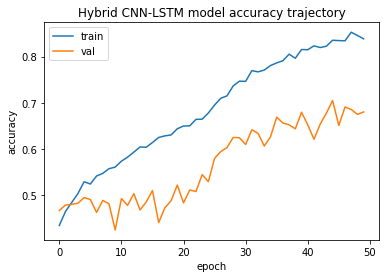

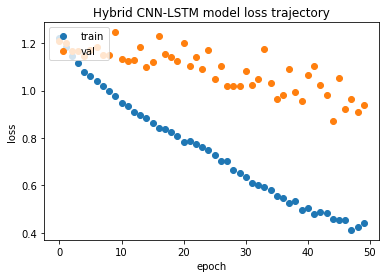

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## (vii)(CNN-LSTM) Testing the performance of the hybrid CNN-LSTM model on the held out test set

In [ ]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Opt

# Transformer

## Attention v1
Replacing LSTM with attention

In [ ]:
inputs = keras.Input(shape=(250,1,22))

# Conv. block 1
x = Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu')(inputs)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Conv. block 2
x = Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Conv. block 3
x = Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Conv. block 4
x = Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Attention+FC layers
x = Flatten()(x)  # Adding a flattening operation to the output of CNN block
x = Dense((100))(x)  # FC layer with 100 units
x = Reshape((100,1))(x)  # Reshape my output of FC layer so that it's compatible
print('before', x.shape)
# x = LSTM(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False)(x)
x = MultiHeadAttention(num_heads=64, key_dim=32, dropout=0.6)(x, x)
print('after', x.shape)
x = Reshape((100,))(x)

# Output layer with Softmax activation 
outputs = Dense(4, activation='softmax')(x)  # Output FC layer with softmax activation

# Defining the model
attention_model = keras.Model(inputs=inputs, outputs=outputs)

# Printing the model summary
attention_model.summary()


before (None, 100, 1)
after (None, 100, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 250, 1, 25)   5525        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 84, 1, 25)    0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 84, 1, 25) 

In [ ]:
# Compiling the model
attention_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
attention_model_results = attention_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)



Streaming output truncated to the last 5000 lines.
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_55947 in device /job:localhost/replica:0/task:0/device:GPU:0
 91/109 [========================>.....] - ETA: 1s - loss: 0.3555 - accuracy: 0.8654Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_55947 in device /job:localhost/replica:0/task:0/device:GPU:0
 92/109 [========================>.....] - ETA: 0s - loss: 0.3544 - accuracy: 0.8660Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_55947 in device /job:localhost/replica:0/task:0/device:GPU:0
 93/109 [========================>.....] - ETA: 0s - loss: 0.3528 - accuracy: 0.8

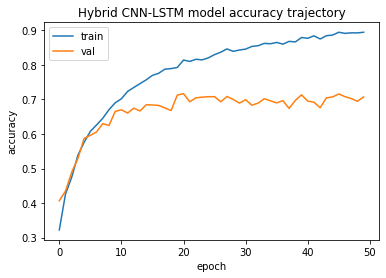

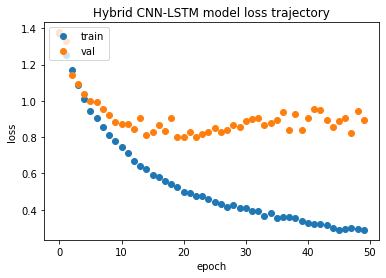

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(attention_model_results.history['accuracy'])
plt.plot(attention_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(attention_model_results.history['loss'],'o')
plt.plot(attention_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the Transformer model

attention_score = attention_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the attention model:', attention_score[1])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Opt

## Attention v2 
Adding attention to the beginning

In [ ]:
inputs = keras.Input(shape=(250,1,22))

# Attention block 1

x = MultiHeadAttention(num_heads=64, key_dim=32, dropout=0.6)(inputs, inputs)

# Conv. block 1
x = Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Conv. block 2
x = Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Conv. block 3
x = Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Conv. block 4
x = Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Attention+FC layers
x = Flatten()(x)  # Adding a flattening operation to the output of CNN block
x = Dense((100))(x)  # FC layer with 100 units
x = Reshape((100,1))(x)  # Reshape my output of FC layer so that it's compatible
print('before', x.shape)
# x = LSTM(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False)(x)
x = MultiHeadAttention(num_heads=64, key_dim=32, dropout=0.6)(x, x)
print('after', x.shape)
x = Reshape((100,))(x)

# Output layer with Softmax activation 
outputs = Dense(4, activation='softmax')(x)  # Output FC layer with softmax activation

# Defining the model
attention_model = keras.Model(inputs=inputs, outputs=outputs)

# Printing the model summary
attention_model.summary()


before (None, 100, 1)
after (None, 100, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 250, 1, 22)  186390      ['input_2[0][0]',                
 eadAttention)                                                    'input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 250, 1, 25)   5525        ['multi_head_attention_1[0][0]'] 
                                                 

In [ ]:
# Compiling the model
attention_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
attention_model_results = attention_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/50
109/109 [==============================] - 42s 347ms/step - loss: 1.3644 - accuracy: 0.3027 - val_loss: 1.2810 - val_accuracy: 0.3973
Epoch 2/50
109/109 [==============================] - 34s 315ms/step - loss: 1.2601 - accuracy: 0.4195 - val_loss: 1.3422 - val_accuracy: 0.4080
Epoch 3/50
109/109 [==============================] - 37s 342ms/step - loss: 1.2217 - accuracy: 0.4389 - val_loss: 1.5327 - val_accuracy: 0.4120
Epoch 4/50
109/109 [==============================] - 34s 315ms/step - loss: 1.2031 - accuracy: 0.4566 - val_loss: 1.2475 - val_accuracy: 0.4500
Epoch 5/50
109/109 [==============================] - 34s 313ms/step - loss: 1.1649 - accuracy: 0.4871 - val_loss: 1.3938 - val_accuracy: 0.4307
Epoch 6/50
109/109 [==============================] - 34s 314ms/step - loss: 1.1331 - accuracy: 0.5092 - val_loss: 1.1605 - val_accuracy: 0.4720
Epoch 7/50
109/109 [==============================] - 34s 313ms/step - loss: 1.0970 - accuracy: 0.5198 - val_loss: 1.1298 - val_ac

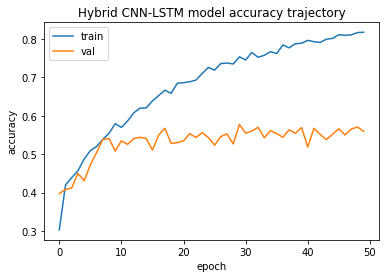

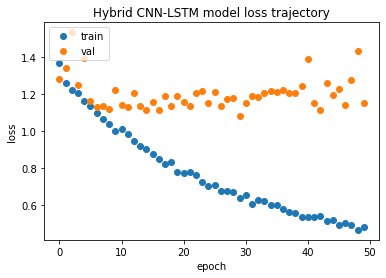

Test accuracy of the attention model: 0.5643340945243835


In [ ]:
# Plotting accuracy trajectory
plt.plot(attention_model_results.history['accuracy'])
plt.plot(attention_model_results.history['val_accuracy'])
plt.title('Hybrid Attention model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(attention_model_results.history['loss'],'o')
plt.plot(attention_model_results.history['val_loss'],'o')
plt.title('Hybrid Attention model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing the Transformer model

attention_score = attention_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the attention model:', attention_score[1])

## Attention v3
Parallel

In [ ]:
inputs = keras.Input(shape=(250,1,22))

# Attention block 1

x = MultiHeadAttention(num_heads=64, key_dim=32, dropout=0.6)(inputs, inputs)

# Conv. block 1
x = Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu')(concatenate([x, inputs]))
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Conv. block 2
x = Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Conv. block 3
x = Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Conv. block 4
x = Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Attention+FC layers
x = Flatten()(x)  # Adding a flattening operation to the output of CNN block
x = Dense((100))(x)  # FC layer with 100 units
x = Reshape((100,1))(x)  # Reshape my output of FC layer so that it's compatible
print('before', x.shape)
# x = LSTM(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False)(x)
x = MultiHeadAttention(num_heads=64, key_dim=32, dropout=0.6)(x, x)
print('after', x.shape)
x = Reshape((100,))(x)

# Output layer with Softmax activation 
outputs = Dense(4, activation='softmax')(x)  # Output FC layer with softmax activation

# Defining the model
attention_model = keras.Model(inputs=inputs, outputs=outputs)

# Printing the model summary
attention_model.summary()

before (None, 100, 1)
after (None, 100, 1)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 250, 1, 22)  186390      ['input_7[0][0]',                
 eadAttention)                                                    'input_7[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 250, 1, 44)   0           ['multi_head_attention_7[0][0]', 
                                                 

In [93]:
# Compiling the model
attention_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
attention_model_results = attention_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

(6960, 4)


NameError: ignored

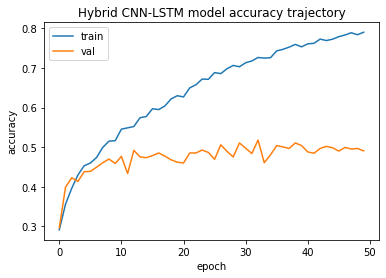

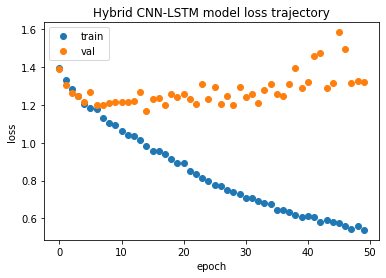

Test accuracy of the attention model: 0.5084649920463562


In [ ]:
# Plotting accuracy trajectory
plt.plot(attention_model_results.history['accuracy'])
plt.plot(attention_model_results.history['val_accuracy'])
plt.title('Hybrid Attention model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(attention_model_results.history['loss'],'o')
plt.plot(attention_model_results.history['val_loss'],'o')
plt.title('Hybrid Attention model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing the Transformer model

attention_score = attention_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the attention model:', attention_score[1])

## Transformer v1

In [ ]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
inputs = keras.Input(shape=(250,1,22))

# Transformer block
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

embedding_layer = TokenAndPositionEmbedding(250, 4, embed_dim)
x = embedding_layer(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
# x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(2, activation="softmax")(x)

# Conv. block 1
x = Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu')(inputs)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Conv. block 2
x = Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Conv. block 3
x = Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Conv. block 4
x = Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu')(x)
x = MaxPooling2D(pool_size=(3,1), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Attention+FC layers
x = Flatten()(x)  # Adding a flattening operation to the output of CNN block
x = Dense((100))(x)  # FC layer with 100 units
x = Reshape((100,1))(x)  # Reshape my output of FC layer so that it's compatible
print('before', x.shape)
# x = LSTM(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False)(x)
x = MultiHeadAttention(num_heads=64, key_dim=32, dropout=0.6)(x, x)
print('after', x.shape)
x = Reshape((100,))(x)

# Output layer with Softmax activation 
outputs = Dense(4, activation='softmax')(x)  # Output FC layer with softmax activation

# Defining the model
transformer_model = keras.Model(inputs=inputs, outputs=outputs)

# Printing the model summary
transformer_model.summary()

before (None, 100, 1)
after (None, 100, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 250, 1, 25)   5525        ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 84, 1, 25)   0           ['conv2d_4[0][0]']               
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 84, 1, 25

In [32]:
# Compiling the model
transformer_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
transformer_model_results = transformer_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

NameError: ignored

## Transformer v2

In [99]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    print('last call', x)
    length = tf.shape(x)[1]
    # length = x.shape[1]
    print(tf.shape(x))
    print(length)
    x = self.embedding(x)
    print('embedding', x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    print('x', x)
    print('embedding', self.pos_embedding)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    print('context', context)
    context = self.encoder(context)  # (batch_size, context_len, d_model)
    print('encoded')

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits


In [100]:
num_layers = 4
d_model = 32
dff = 128
num_heads = 4
dropout_rate = 0.3
# test
input_vocab_size=2500
target_vocab_size=4

inputs = keras.Input(shape=(1000))
 
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    dropout_rate=dropout_rate)

tm = transformer((inputs, inputs))

tm = Flatten()(tm)

# Output layer with Softmax activation 
outputs = Dense(4, activation='softmax')(tm)  # Output FC layer with softmax activation

transformer_model = keras.Model(inputs=inputs, outputs=outputs)

transformer_model.summary()

context Tensor("Placeholder:0", shape=(None, 1000), dtype=float32)
x Tensor("Placeholder:0", shape=(None, 1000), dtype=float32)
embedding <__main__.PositionalEmbedding object at 0x7f695024b970>
last call Tensor("Placeholder:0", shape=(None, 1000), dtype=float32)
Tensor("transformer_40/encoder_40/positional_embedding_80/Shape_1:0", shape=(2,), dtype=int32)
Tensor("transformer_40/encoder_40/positional_embedding_80/strided_slice:0", shape=(), dtype=int32)
embedding Tensor("transformer_40/encoder_40/positional_embedding_80/embedding_80/embedding_lookup/Identity_1:0", shape=(None, 1000, 32), dtype=float32)
encoded
last call Tensor("Placeholder_1:0", shape=(None, 1000), dtype=float32)
Tensor("transformer_40/decoder_40/positional_embedding_81/Shape_1:0", shape=(2,), dtype=int32)
Tensor("transformer_40/decoder_40/positional_embedding_81/strided_slice:0", shape=(), dtype=int32)
embedding Tensor("transformer_40/decoder_40/positional_embedding_81/embedding_81/embedding_lookup/Identity_1:0", shape

In [101]:
tf.debugging.disable_traceback_filtering()
# Compiling the model
transformer_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
transformer_model_results = transformer_model.fit(X_train_tm[:, 0, :],
             y_train_tm,
             batch_size=64,
             epochs=epochs,
             validation_data=(X_valid_tm[:, 0, :], y_valid_tm), verbose=True)

Epoch 1/50
context Tensor("IteratorGetNext:0", shape=(None, 1000), dtype=float32)
x Tensor("IteratorGetNext:0", shape=(None, 1000), dtype=float32)
embedding <__main__.PositionalEmbedding object at 0x7f695024b970>
last call Tensor("IteratorGetNext:0", shape=(None, 1000), dtype=float32)
Tensor("model_9/transformer_40/encoder_40/positional_embedding_80/Shape_1:0", shape=(2,), dtype=int32)
Tensor("model_9/transformer_40/encoder_40/positional_embedding_80/strided_slice:0", shape=(), dtype=int32)
embedding Tensor("model_9/transformer_40/encoder_40/positional_embedding_80/embedding_80/embedding_lookup/Identity_1:0", shape=(None, 1000, 32), dtype=float32)
encoded
last call Tensor("IteratorGetNext:0", shape=(None, 1000), dtype=float32)
Tensor("model_9/transformer_40/decoder_40/positional_embedding_81/Shape_1:0", shape=(2,), dtype=int32)
Tensor("model_9/transformer_40/decoder_40/positional_embedding_81/strided_slice:0", shape=(), dtype=int32)
embedding Tensor("model_9/transformer_40/decoder_40/p

InvalidArgumentError: ignored